# [실습 1]

## 1. Load Library & Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from dataset.mnist import load_mnist

(train_raw_img, train_label), (test_raw_img, test_label) = load_mnist(flatten=False, normalize=False)
print(train_raw_img.shape)

## 2. Preprocessing & Visualization

In [ ]:
np.unique(train_label, return_counts=True)

In [ ]:
# 각 레이블 분포
sns.countplot(train_label)
plt.title("Distribution of Labels")
plt.show()

In [ ]:
# preprocessing (train & inference)
train_img = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
train_label = train_label.reshape(len(train_label), -1)

test_img = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)
test_label = test_label.reshape(len(test_label), -1)

print(train_img.shape)
print(train_label.shape)
print(test_img.shape)
print(test_label.shape)

In [ ]:
# display a few digits from the training set
fig, axs = plt.subplots(2, 5, figsize=(12,6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in np.arange(0, 10):
    axs[i].imshow(train_img[i].reshape(28, 28), cmap='gray')
    axs[i].set_title("Label = {}".format(train_label[i]))
    axs[i].axis('off')
plt.show()

In [ ]:
# normalization (set value 0 ~ 1)
train_img = train_img.astype('float')
train_img = train_img/255

test_img = test_img.astype('float')
test_img = test_img/255

## model

In [ ]:
class Linear:
    def __init__(self, input_size=1, hidden_size=1):
        self.W = np.random.randn(input_size, hidden_size)
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout, lr):
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.x.T, dout)
        dx = np.dot(dout, self.W.T)
        
        self.W -= lr * self.dW
        self.b -= lr * self.db
        
        return dx

# [실습 1] activation function 구현

In [ ]:
# Activation function
class Relu:
    def __init__(self) :
        self.mask =None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        return dout    

class Leaky_Relu:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] *= self.alpha
        return out
    
    def backward(self, dout):
        dout[self.mask] *= self.alpha
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x)) # Sigmoid 함수 계산
        self.out = out # 역전파를 위해 출력 저장
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out) # Sigmoid 함수의 역전파 계산식 적용
        return dx

class TanH:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = np.tanh(x) # TanH 함수 계산
        self.out = out # 역전파를 위해 출력 저장
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out**2) # TanH 함수의 역전파 계산식 적용
        return dx

In [ ]:
class Softmax_with_CrossEntropy :
    def __init__(self) :
        # softmax
        self.softmax_x = None 
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.delta = 1e-7
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        tmp = np.max(self.softmax_x, axis=1).reshape(-1, 1)
        self.softmax_out = np.exp(self.softmax_x-tmp)/np.sum(np.exp(self.softmax_x-tmp), axis=1).reshape(-1,1)
        return self.softmax_out
    
    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        loss = -np.sum(self.target*np.log(self.pred+self.delta), axis=1)
        return loss
    
    def backward(self) :
        dout = (self.pred-self.target)/len(self.pred)
        return dout

## Train / Eval

In [ ]:
# one_hot label 만드는 함수
def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

one_hot_labels = make_one_hot(train_label)
print(train_label[0])
print(one_hot_labels[0])

In [ ]:
def eval(model, train_version = True) :
    if train_version :
        x = train_img
        labels = train_label.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_img
        labels = test_label.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, Softmax_with_CrossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

In [ ]:
from collections import OrderedDict

def train_MLP(config) :
    # 손실 이력을 저장하는 리스트
    loss_history = []
    
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 25
    
    layer1 = Linear(784, 100)
    activation_function = config['activation_function']
    layer2 = Linear(100, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()
    
    for iter in range(num_epoch) :
        # forward
        x = layer1.forward(train_img)
        x = activation_function.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_label)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        
        # backward
        dL = softmax_with_CE.backward()
        dL = layer2.backward(dL, lr)
        dL = activation_function.backward(dL)
        dL = layer1.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
    
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model

In [14]:
config1 = { 'learning_rate' : 0.1,
            'num_epoch' : 300,
            'activation_function' : Relu()
          }

config2 = { 'learning_rate' : 0.1,
            'num_epoch' : 300,
            'activation_function' : Leaky_Relu()
          }

config3 = { 'learning_rate' : 0.1,
            'num_epoch' : 300,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.1,
            'num_epoch' : 300,
            'activation_function' : TanH()
          }

---ReLU---
[epoch 1 / 300] average loss : 13.509241
[epoch 25 / 300] average loss : 5.005926
[epoch 50 / 300] average loss : 3.511457
[epoch 75 / 300] average loss : 2.886961
[epoch 100 / 300] average loss : 2.511231
[epoch 125 / 300] average loss : 2.254165
[epoch 150 / 300] average loss : 2.066757
[epoch 175 / 300] average loss : 1.921290
[epoch 200 / 300] average loss : 1.801115
[epoch 225 / 300] average loss : 1.701067
[epoch 250 / 300] average loss : 1.616539
[epoch 275 / 300] average loss : 1.543391
[epoch 300 / 300] average loss : 1.479103


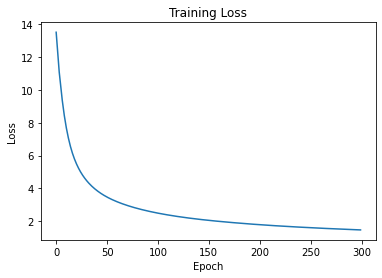

In [23]:
print('---ReLU---')
model1 = train_MLP(config1)


---Leaky_Relu---
[epoch 1 / 300] average loss : 14.575231
[epoch 25 / 300] average loss : 4.761853
[epoch 50 / 300] average loss : 3.341477
[epoch 75 / 300] average loss : 2.738005
[epoch 100 / 300] average loss : 2.383442
[epoch 125 / 300] average loss : 2.146173
[epoch 150 / 300] average loss : 1.973759
[epoch 175 / 300] average loss : 1.841781
[epoch 200 / 300] average loss : 1.736407
[epoch 225 / 300] average loss : 1.647861
[epoch 250 / 300] average loss : 1.572009
[epoch 275 / 300] average loss : 1.505686
[epoch 300 / 300] average loss : 1.447035


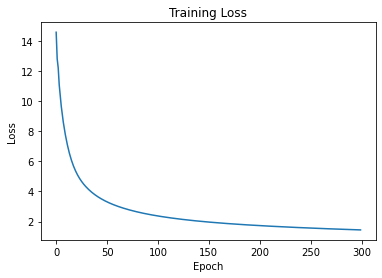

In [24]:
print('\n---Leaky_Relu---')
model2 = train_MLP(config2)


---Sigmoid---
[epoch 1 / 300] average loss : 9.148506
[epoch 25 / 300] average loss : 5.325003
[epoch 50 / 300] average loss : 4.049878
[epoch 75 / 300] average loss : 3.217097
[epoch 100 / 300] average loss : 2.664985
[epoch 125 / 300] average loss : 2.287128
[epoch 150 / 300] average loss : 2.018745
[epoch 175 / 300] average loss : 1.820445
[epoch 200 / 300] average loss : 1.668470
[epoch 225 / 300] average loss : 1.548371
[epoch 250 / 300] average loss : 1.451030
[epoch 275 / 300] average loss : 1.370449
[epoch 300 / 300] average loss : 1.302529


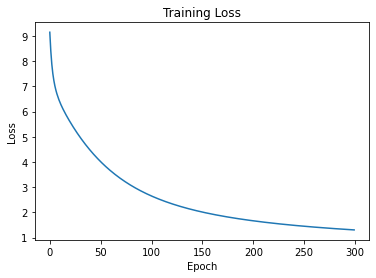

In [25]:
print('\n---Sigmoid---')
model3 = train_MLP(config3)


---TanH---
[epoch 1 / 300] average loss : 10.411758
[epoch 25 / 300] average loss : 5.867404
[epoch 50 / 300] average loss : 4.167454
[epoch 75 / 300] average loss : 3.337429
[epoch 100 / 300] average loss : 2.843045
[epoch 125 / 300] average loss : 2.509883
[epoch 150 / 300] average loss : 2.268453
[epoch 175 / 300] average loss : 2.083569
[epoch 200 / 300] average loss : 1.936239
[epoch 225 / 300] average loss : 1.815787
[epoch 250 / 300] average loss : 1.715306
[epoch 275 / 300] average loss : 1.629950
[epoch 300 / 300] average loss : 1.556235


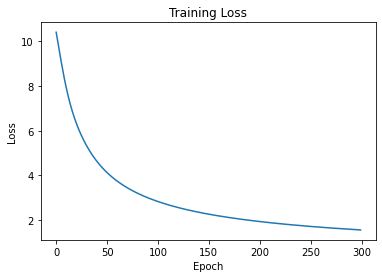

In [26]:
print('\n---TanH---')
model4 = train_MLP(config4)

In [27]:
# evaluation
print('\t Accuracy :', eval(model1, train_version=False))
print('\t Accuracy :', eval(model2, train_version=False))
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.8455

In test dataset ... 
	 Accuracy : 0.858

In test dataset ... 
	 Accuracy : 0.64

In test dataset ... 
	 Accuracy : 0.7194


In [28]:
config1 = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : Relu()
          }

config2 = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : Leaky_Relu()
          }

config3 = { 'learning_rate' : 0.1,
            'num_epoch' : 200,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.1,
            'num_epoch' : 200,
            'activation_function' : TanH()
          }

---ReLU---
[epoch 1 / 100] average loss : 14.539629
[epoch 25 / 100] average loss : 4.698366
[epoch 50 / 100] average loss : 3.285909
[epoch 75 / 100] average loss : 2.715566
[epoch 100 / 100] average loss : 2.385390


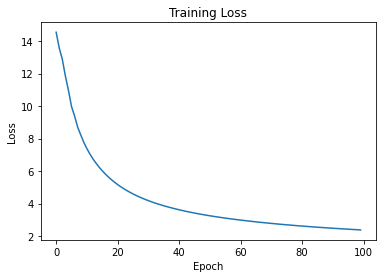

In [29]:
print('---ReLU---')
model1 = train_MLP(config1)


---Leaky_Relu---
[epoch 1 / 100] average loss : 13.890225
[epoch 25 / 100] average loss : 4.894595
[epoch 50 / 100] average loss : 3.508201
[epoch 75 / 100] average loss : 2.909575
[epoch 100 / 100] average loss : 2.552634


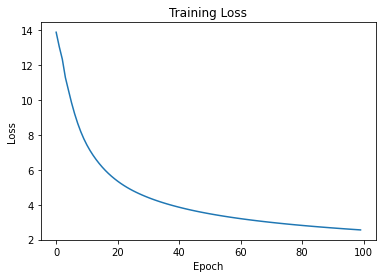

In [30]:
print('\n---Leaky_Relu---')
model2 = train_MLP(config2)


---Sigmoid---
[epoch 1 / 200] average loss : 8.127881
[epoch 25 / 200] average loss : 4.205105
[epoch 50 / 200] average loss : 3.268014
[epoch 75 / 200] average loss : 2.748512
[epoch 100 / 200] average loss : 2.386862
[epoch 125 / 200] average loss : 2.123659
[epoch 150 / 200] average loss : 1.924457
[epoch 175 / 200] average loss : 1.768536
[epoch 200 / 200] average loss : 1.643116


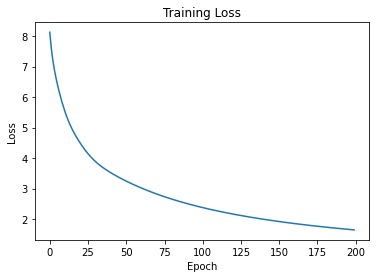

In [31]:
print('\n---Sigmoid---')
model3 = train_MLP(config3)


---TanH---
[epoch 1 / 200] average loss : 10.573138
[epoch 25 / 200] average loss : 6.846401
[epoch 50 / 200] average loss : 4.751224
[epoch 75 / 200] average loss : 3.667658
[epoch 100 / 200] average loss : 3.054923
[epoch 125 / 200] average loss : 2.662687
[epoch 150 / 200] average loss : 2.384633
[epoch 175 / 200] average loss : 2.174832
[epoch 200 / 200] average loss : 2.009665


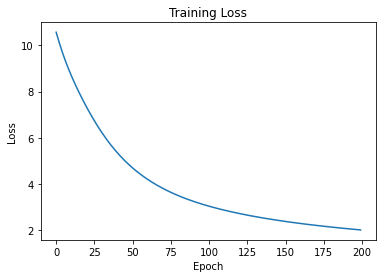

In [32]:
print('\n---TanH---')
model4 = train_MLP(config4)

In [33]:
# evaluation
print('\t Accuracy :', eval(model1, train_version=False))
print('\t Accuracy :', eval(model2, train_version=False))
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.7941

In test dataset ... 
	 Accuracy : 0.7871

In test dataset ... 
	 Accuracy : 0.5843

In test dataset ... 
	 Accuracy : 0.6491


In [59]:
config1 = { 'learning_rate' : 0.01,
            'num_epoch' : 3000,
            'activation_function' : Relu()
          }

config2 = { 'learning_rate' : 0.01,
            'num_epoch' : 3000,
            'activation_function' : Leaky_Relu()
          }

config3 = { 'learning_rate' : 0.01,
            'num_epoch' : 3000,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.01,
            'num_epoch' : 3000,
            'activation_function' : TanH()
          }

---ReLU---
[epoch 1 / 3000] average loss : 13.696677
[epoch 25 / 3000] average loss : 11.926090
[epoch 50 / 3000] average loss : 10.003870
[epoch 75 / 3000] average loss : 8.580126
[epoch 100 / 3000] average loss : 7.492574
[epoch 125 / 3000] average loss : 6.672298
[epoch 150 / 3000] average loss : 6.041483
[epoch 175 / 3000] average loss : 5.553898
[epoch 200 / 3000] average loss : 5.171201
[epoch 225 / 3000] average loss : 4.857722
[epoch 250 / 3000] average loss : 4.595574
[epoch 275 / 3000] average loss : 4.373777
[epoch 300 / 3000] average loss : 4.183605
[epoch 325 / 3000] average loss : 4.016924
[epoch 350 / 3000] average loss : 3.868254
[epoch 375 / 3000] average loss : 3.735346
[epoch 400 / 3000] average loss : 3.616254
[epoch 425 / 3000] average loss : 3.508384
[epoch 450 / 3000] average loss : 3.409838
[epoch 475 / 3000] average loss : 3.319560
[epoch 500 / 3000] average loss : 3.236850
[epoch 525 / 3000] average loss : 3.160756
[epoch 550 / 3000] average loss : 3.090731
[e

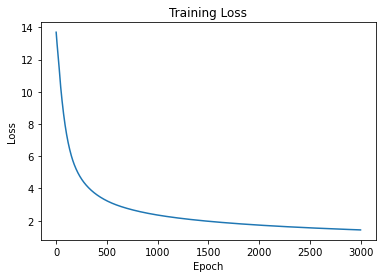

In [60]:
print('---ReLU---')
model1 = train_MLP(config1)


---Leaky_Relu---
[epoch 1 / 3000] average loss : 14.780716
[epoch 25 / 3000] average loss : 12.403573
[epoch 50 / 3000] average loss : 10.203321
[epoch 75 / 3000] average loss : 8.715111
[epoch 100 / 3000] average loss : 7.669432
[epoch 125 / 3000] average loss : 6.865401
[epoch 150 / 3000] average loss : 6.241101
[epoch 175 / 3000] average loss : 5.745457
[epoch 200 / 3000] average loss : 5.338298
[epoch 225 / 3000] average loss : 4.998350
[epoch 250 / 3000] average loss : 4.710287
[epoch 275 / 3000] average loss : 4.462497
[epoch 300 / 3000] average loss : 4.249077
[epoch 325 / 3000] average loss : 4.064050
[epoch 350 / 3000] average loss : 3.902633
[epoch 375 / 3000] average loss : 3.759950
[epoch 400 / 3000] average loss : 3.632274
[epoch 425 / 3000] average loss : 3.517667
[epoch 450 / 3000] average loss : 3.414121
[epoch 475 / 3000] average loss : 3.320300
[epoch 500 / 3000] average loss : 3.234977
[epoch 525 / 3000] average loss : 3.156832
[epoch 550 / 3000] average loss : 3.08

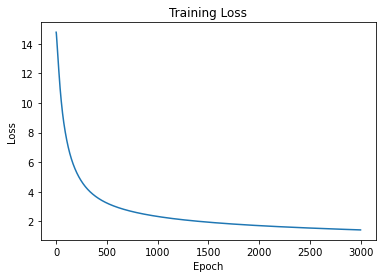

In [61]:
print('\n---Leaky_Relu---')
model2 = train_MLP(config2)


---Sigmoid---
[epoch 1 / 3000] average loss : 9.526525
[epoch 25 / 3000] average loss : 8.598040
[epoch 50 / 3000] average loss : 8.053628
[epoch 75 / 3000] average loss : 7.650710
[epoch 100 / 3000] average loss : 7.312843
[epoch 125 / 3000] average loss : 7.009913
[epoch 150 / 3000] average loss : 6.722768
[epoch 175 / 3000] average loss : 6.441984
[epoch 200 / 3000] average loss : 6.167519
[epoch 225 / 3000] average loss : 5.904313
[epoch 250 / 3000] average loss : 5.656273
[epoch 275 / 3000] average loss : 5.423258
[epoch 300 / 3000] average loss : 5.203400
[epoch 325 / 3000] average loss : 4.996769
[epoch 350 / 3000] average loss : 4.806087
[epoch 375 / 3000] average loss : 4.634733
[epoch 400 / 3000] average loss : 4.483906
[epoch 425 / 3000] average loss : 4.351446
[epoch 450 / 3000] average loss : 4.233180
[epoch 475 / 3000] average loss : 4.125034
[epoch 500 / 3000] average loss : 4.024129
[epoch 525 / 3000] average loss : 3.928782
[epoch 550 / 3000] average loss : 3.838089
[

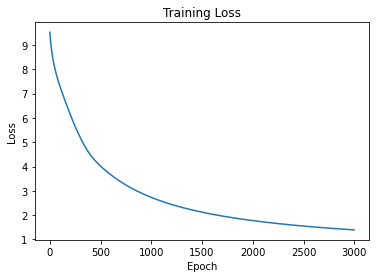

In [62]:
print('\n---Sigmoid---')
model3 = train_MLP(config3)


---TanH---
[epoch 1 / 3000] average loss : 11.433281
[epoch 25 / 3000] average loss : 10.444394
[epoch 50 / 3000] average loss : 9.705804
[epoch 75 / 3000] average loss : 9.125116
[epoch 100 / 3000] average loss : 8.636917
[epoch 125 / 3000] average loss : 8.210117
[epoch 150 / 3000] average loss : 7.828274
[epoch 175 / 3000] average loss : 7.481413
[epoch 200 / 3000] average loss : 7.163860
[epoch 225 / 3000] average loss : 6.871527
[epoch 250 / 3000] average loss : 6.601324
[epoch 275 / 3000] average loss : 6.351085
[epoch 300 / 3000] average loss : 6.118921
[epoch 325 / 3000] average loss : 5.903265
[epoch 350 / 3000] average loss : 5.702773
[epoch 375 / 3000] average loss : 5.516113
[epoch 400 / 3000] average loss : 5.342011
[epoch 425 / 3000] average loss : 5.179303
[epoch 450 / 3000] average loss : 5.026976
[epoch 475 / 3000] average loss : 4.884171
[epoch 500 / 3000] average loss : 4.750106
[epoch 525 / 3000] average loss : 4.624061
[epoch 550 / 3000] average loss : 4.505402
[e

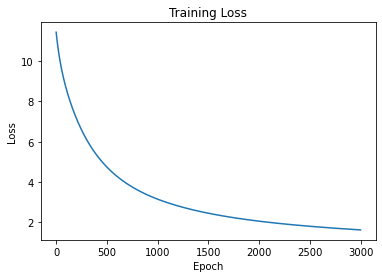

In [63]:
print('\n---TanH---')
model4 = train_MLP(config4)

In [64]:
# evaluation
print('\t Accuracy :', eval(model1, train_version=False))
print('\t Accuracy :', eval(model2, train_version=False))
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.8477

In test dataset ... 
	 Accuracy : 0.8503

In test dataset ... 
	 Accuracy : 0.6284

In test dataset ... 
	 Accuracy : 0.7055


In [67]:
config3 = { 'learning_rate' : 0.01,
            'num_epoch' : 5000,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.01,
            'num_epoch' : 5000,
            'activation_function' : TanH()
          }


---Sigmoid---
[epoch 1 / 5000] average loss : 9.395990
[epoch 25 / 5000] average loss : 8.669212
[epoch 50 / 5000] average loss : 8.069619
[epoch 75 / 5000] average loss : 7.528647
[epoch 100 / 5000] average loss : 7.028837
[epoch 125 / 5000] average loss : 6.570342
[epoch 150 / 5000] average loss : 6.157922
[epoch 175 / 5000] average loss : 5.794744
[epoch 200 / 5000] average loss : 5.482709
[epoch 225 / 5000] average loss : 5.220841
[epoch 250 / 5000] average loss : 5.003460
[epoch 275 / 5000] average loss : 4.822179
[epoch 300 / 5000] average loss : 4.668264
[epoch 325 / 5000] average loss : 4.533737
[epoch 350 / 5000] average loss : 4.412232
[epoch 375 / 5000] average loss : 4.299468
[epoch 400 / 5000] average loss : 4.192966
[epoch 425 / 5000] average loss : 4.091423
[epoch 450 / 5000] average loss : 3.994174
[epoch 475 / 5000] average loss : 3.900859
[epoch 500 / 5000] average loss : 3.811255
[epoch 525 / 5000] average loss : 3.725195
[epoch 550 / 5000] average loss : 3.642538
[

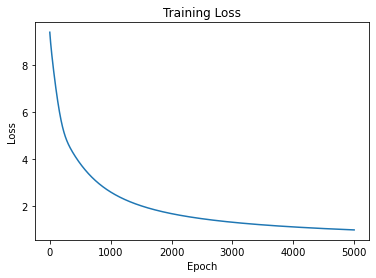

In [68]:
print('\n---Sigmoid---')
model3 = train_MLP(config3)


---TanH---
[epoch 1 / 5000] average loss : 10.742209
[epoch 25 / 5000] average loss : 10.029517
[epoch 50 / 5000] average loss : 9.404105
[epoch 75 / 5000] average loss : 8.871341
[epoch 100 / 5000] average loss : 8.408404
[epoch 125 / 5000] average loss : 7.998132
[epoch 150 / 5000] average loss : 7.629040
[epoch 175 / 5000] average loss : 7.292619
[epoch 200 / 5000] average loss : 6.983114
[epoch 225 / 5000] average loss : 6.697135
[epoch 250 / 5000] average loss : 6.432185
[epoch 275 / 5000] average loss : 6.186103
[epoch 300 / 5000] average loss : 5.957180
[epoch 325 / 5000] average loss : 5.744063
[epoch 350 / 5000] average loss : 5.545473
[epoch 375 / 5000] average loss : 5.360125
[epoch 400 / 5000] average loss : 5.186896
[epoch 425 / 5000] average loss : 5.024882
[epoch 450 / 5000] average loss : 4.873283
[epoch 475 / 5000] average loss : 4.731314
[epoch 500 / 5000] average loss : 4.598206
[epoch 525 / 5000] average loss : 4.473221
[epoch 550 / 5000] average loss : 4.355661
[e

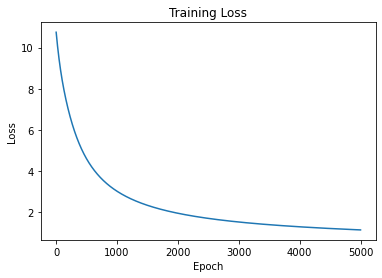

In [69]:
print('\n---TanH---')
model4 = train_MLP(config4)

In [70]:
# evaluation
print('\t Accuracy :', eval(model1, train_version=False))
print('\t Accuracy :', eval(model2, train_version=False))
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.8477

In test dataset ... 
	 Accuracy : 0.8503

In test dataset ... 
	 Accuracy : 0.7211

In test dataset ... 
	 Accuracy : 0.7641


In [16]:
config3 = { 'learning_rate' : 0.01,
            'num_epoch' : 7000,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.01,
            'num_epoch' : 7000,
            'activation_function' : TanH()
          }


---Sigmoid---
[epoch 1 / 7000] average loss : 11.675461
[epoch 25 / 7000] average loss : 9.631304
[epoch 50 / 7000] average loss : 8.392589
[epoch 75 / 7000] average loss : 7.534319
[epoch 100 / 7000] average loss : 6.870940
[epoch 125 / 7000] average loss : 6.323816
[epoch 150 / 7000] average loss : 5.869791
[epoch 175 / 7000] average loss : 5.498978
[epoch 200 / 7000] average loss : 5.196605
[epoch 225 / 7000] average loss : 4.948791
[epoch 250 / 7000] average loss : 4.745988
[epoch 275 / 7000] average loss : 4.578885
[epoch 300 / 7000] average loss : 4.436827
[epoch 325 / 7000] average loss : 4.310580
[epoch 350 / 7000] average loss : 4.194290
[epoch 375 / 7000] average loss : 4.084981
[epoch 400 / 7000] average loss : 3.981302
[epoch 425 / 7000] average loss : 3.882626
[epoch 450 / 7000] average loss : 3.788603
[epoch 475 / 7000] average loss : 3.698986
[epoch 500 / 7000] average loss : 3.613557
[epoch 525 / 7000] average loss : 3.532112
[epoch 550 / 7000] average loss : 3.454448


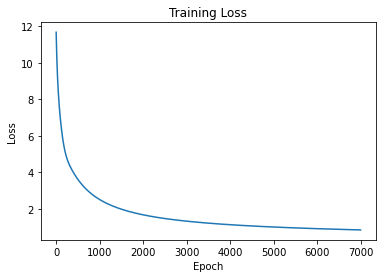

In [17]:
print('\n---Sigmoid---')
model3 = train_MLP(config3)


---TanH---
[epoch 1 / 7000] average loss : 11.691763
[epoch 25 / 7000] average loss : 11.140742
[epoch 50 / 7000] average loss : 10.538687
[epoch 75 / 7000] average loss : 9.932408
[epoch 100 / 7000] average loss : 9.353304
[epoch 125 / 7000] average loss : 8.824469
[epoch 150 / 7000] average loss : 8.353172
[epoch 175 / 7000] average loss : 7.934937
[epoch 200 / 7000] average loss : 7.562401
[epoch 225 / 7000] average loss : 7.227673
[epoch 250 / 7000] average loss : 6.924404
[epoch 275 / 7000] average loss : 6.647588
[epoch 300 / 7000] average loss : 6.393249
[epoch 325 / 7000] average loss : 6.158338
[epoch 350 / 7000] average loss : 5.940592
[epoch 375 / 7000] average loss : 5.738180
[epoch 400 / 7000] average loss : 5.549672
[epoch 425 / 7000] average loss : 5.373978
[epoch 450 / 7000] average loss : 5.210075
[epoch 475 / 7000] average loss : 5.056912
[epoch 500 / 7000] average loss : 4.913491
[epoch 525 / 7000] average loss : 4.778926
[epoch 550 / 7000] average loss : 4.652441
[

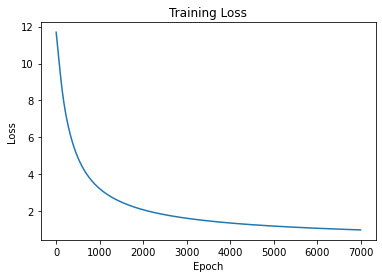

In [18]:
print('\n---TanH---')
model4 = train_MLP(config4)

In [20]:
# evaluation
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.7648

In test dataset ... 
	 Accuracy : 0.7878


In [21]:
config3 = { 'learning_rate' : 0.01,
            'num_epoch' : 10000,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.01,
            'num_epoch' : 10000,
            'activation_function' : TanH()
          }


---Sigmoid---
[epoch 1 / 10000] average loss : 10.777564
[epoch 25 / 10000] average loss : 8.551050
[epoch 50 / 10000] average loss : 7.160719
[epoch 75 / 10000] average loss : 6.417728
[epoch 100 / 10000] average loss : 5.966333
[epoch 125 / 10000] average loss : 5.637957
[epoch 150 / 10000] average loss : 5.367465
[epoch 175 / 10000] average loss : 5.132389
[epoch 200 / 10000] average loss : 4.926262
[epoch 225 / 10000] average loss : 4.746548
[epoch 250 / 10000] average loss : 4.589662
[epoch 275 / 10000] average loss : 4.450564
[epoch 300 / 10000] average loss : 4.324278
[epoch 325 / 10000] average loss : 4.207062
[epoch 350 / 10000] average loss : 4.096564
[epoch 375 / 10000] average loss : 3.991450
[epoch 400 / 10000] average loss : 3.890985
[epoch 425 / 10000] average loss : 3.794739
[epoch 450 / 10000] average loss : 3.702430
[epoch 475 / 10000] average loss : 3.613847
[epoch 500 / 10000] average loss : 3.528810
[epoch 525 / 10000] average loss : 3.447157
[epoch 550 / 10000] a

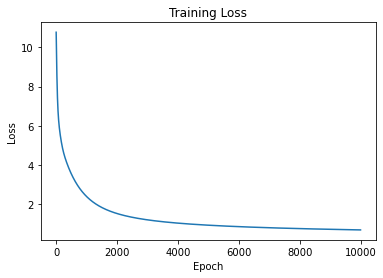

In [22]:
print('\n---Sigmoid---')
model3 = train_MLP(config3)


---TanH---
[epoch 1 / 10000] average loss : 10.536902
[epoch 25 / 10000] average loss : 9.901042
[epoch 50 / 10000] average loss : 9.316816
[epoch 75 / 10000] average loss : 8.788816
[epoch 100 / 10000] average loss : 8.310540
[epoch 125 / 10000] average loss : 7.878293
[epoch 150 / 10000] average loss : 7.488184
[epoch 175 / 10000] average loss : 7.135904
[epoch 200 / 10000] average loss : 6.816814
[epoch 225 / 10000] average loss : 6.526491
[epoch 250 / 10000] average loss : 6.261195
[epoch 275 / 10000] average loss : 6.017783
[epoch 300 / 10000] average loss : 5.793627
[epoch 325 / 10000] average loss : 5.586615
[epoch 350 / 10000] average loss : 5.395024
[epoch 375 / 10000] average loss : 5.217376
[epoch 400 / 10000] average loss : 5.052381
[epoch 425 / 10000] average loss : 4.898861
[epoch 450 / 10000] average loss : 4.755717
[epoch 475 / 10000] average loss : 4.621944
[epoch 500 / 10000] average loss : 4.496642
[epoch 525 / 10000] average loss : 4.379018
[epoch 550 / 10000] aver

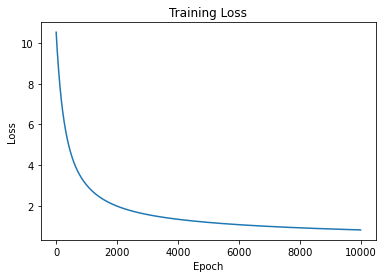

In [23]:
print('\n---TanH---')
model4 = train_MLP(config4)

In [24]:
# evaluation
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.8076

In test dataset ... 
	 Accuracy : 0.8141


# [실습 2] type of gradient descent

In [43]:
def train_MLP_v2(config):
    # 손실 이력을 저장하는 리스트
    loss_history = []
    
    lr, num_epoch, batch_size = config['learning_rate'], config['num_epoch'], config['batch_size']
    print_loss_interval = 25
    
    layer1 = Linear(784, 100)
    activation_function = config['activation_function']
    layer2 = Linear(100, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()
    
    for iter in range(num_epoch):
        total_loss = 0
        for i in range(0, len(train_img), batch_size):
            # forward
            x = layer1.forward(train_img[i:i+batch_size])
            x = activation_function.forward(x)
            x = layer2.forward(x)
            preds = softmax_with_CE.softmax_forward(x)

            # loss
            one_hot_labels = make_one_hot(train_label[i:i+batch_size])
            losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
            loss = losses.sum() / len(preds)
            total_loss += loss

            # backward
            dL = softmax_with_CE.backward()
            dL = layer2.backward(dL, lr)
            dL = activation_function.backward(dL)
            dL = layer1.backward(dL, lr)

        # average loss
        loss = total_loss / (len(train_img) // batch_size)

        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        

        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss)) 

        if loss < 0.05: break
            
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE

    return model

---batch---
[epoch 1 / 3000] average loss : 14.207438
[epoch 25 / 3000] average loss : 11.960615
[epoch 50 / 3000] average loss : 10.037647
[epoch 75 / 3000] average loss : 8.659055
[epoch 100 / 3000] average loss : 7.658463
[epoch 125 / 3000] average loss : 6.891501
[epoch 150 / 3000] average loss : 6.303156
[epoch 175 / 3000] average loss : 5.833448
[epoch 200 / 3000] average loss : 5.450511
[epoch 225 / 3000] average loss : 5.131851
[epoch 250 / 3000] average loss : 4.861985
[epoch 275 / 3000] average loss : 4.627742
[epoch 300 / 3000] average loss : 4.424582
[epoch 325 / 3000] average loss : 4.246686
[epoch 350 / 3000] average loss : 4.090249
[epoch 375 / 3000] average loss : 3.951028
[epoch 400 / 3000] average loss : 3.825147
[epoch 425 / 3000] average loss : 3.710051
[epoch 450 / 3000] average loss : 3.604526
[epoch 475 / 3000] average loss : 3.507521
[epoch 500 / 3000] average loss : 3.418419
[epoch 525 / 3000] average loss : 3.336283
[epoch 550 / 3000] average loss : 3.260070
[

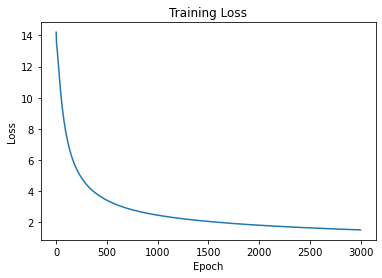

In [21]:
print('---batch---')
config_batch = { 'learning_rate' : 0.01,
            'num_epoch' : 3000,
            'activation_function' : Relu(),
            'batch_size' : len(train_img)
          }
model_batch = train_MLP_v2(config_batch)


---mini_batch---
[epoch 1 / 300] average loss : 1.565256
[epoch 25 / 300] average loss : 0.137752
[epoch 50 / 300] average loss : 0.079897


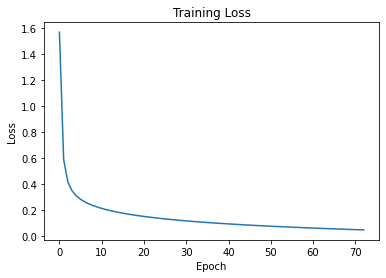

In [22]:
print('\n---mini_batch---')
config_mini_batch = { 'learning_rate' : 0.01,
            'num_epoch' : 300,
            'activation_function' : Relu(),
            'batch_size' : 5 # fill the mini_batch size
          }
model_mini_batch = train_MLP_v2(config_mini_batch)


---stochastic---
[epoch 1 / 100] average loss : 0.817892
[epoch 25 / 100] average loss : 0.055228


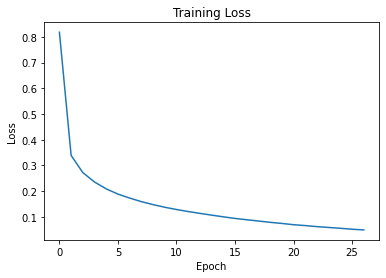

In [23]:
print('\n---stochastic---')
config_stochastic = { 'learning_rate' : 0.01,
            'num_epoch' : 100,
            'activation_function' : Relu(),
            'batch_size' : 1
          }
model_stochastic = train_MLP_v2(config_stochastic)

In [24]:
print('\t Accuracy :', eval(model_batch, train_version=False))
print('\t Accuracy :', eval(model_mini_batch, train_version=False))
print('\t Accuracy :', eval(model_stochastic, train_version=False))


In test dataset ... 
	 Accuracy : 0.8457

In test dataset ... 
	 Accuracy : 0.9522

In test dataset ... 
	 Accuracy : 0.95


# Extra problem 1 (Multi Support Vector Machine)

In [66]:
def MSVM_eval(model, train_version=True):
    if train_version:
        x = train_img
        labels = train_label.squeeze()
        print('In train dataset ...')
    else:
        x = test_img
        labels = test_label.squeeze()
        print('\nIn test dataset ...')

    for layer in model.values():
        if isinstance(layer, MSVM):
            _ = layer.forward(x, labels)
        else:
            x = layer.forward(x)

        if isinstance(layer, MSVM):
            x = layer.pred

    preds = x.argmax(axis=1)
    acc = (preds == labels).mean()
    return acc

In [62]:
class MSVM:
    def __init__(self):
        self.delta = 1e-7
        self.pred = None
        self.target = None

    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        correct_class_score = np.choose(target.flatten(), pred.T)
        margins = np.maximum(0, pred - correct_class_score[:, np.newaxis] + self.delta)
        margins[np.arange(len(target)), target.flatten()] = 0
        loss = np.sum(margins) / len(target)
        return loss

    def backward(self):
        correct_class_score = np.choose(self.target.flatten(), self.pred.T)
        margins = np.maximum(0, self.pred - correct_class_score[:, np.newaxis] + self.delta)
        margins[np.arange(len(self.target)), self.target.flatten()] = 0
        binary = np.where(margins > 0, 1, 0)
        binary[np.arange(len(self.target)), self.target.flatten()] = -np.sum(binary, axis=1)
        dL = binary / len(self.target)
        return dL

In [32]:
def train_MSVM(config):
    # 손실 이력을 저장하는 리스트
    loss_history = []

    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 25

    layer1 = Linear(784, 100)
    activation_function = config['activation_function']
    layer2 = Linear(100, 10)
    msvm_loss = MSVM()
    
    for iter in range(num_epoch):
        # forward
        x = layer1.forward(train_img)
        x = activation_function.forward(x)
        x = layer2.forward(x)
        
        # loss
        loss = msvm_loss.forward(x, train_label.squeeze())
        
        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
        
        # backward
        dL = msvm_loss.backward()
        dL = layer2.backward(dL, lr)
        dL = activation_function.backward(dL)
        dL = layer1.backward(dL, lr)
        
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['msvm_loss'] = msvm_loss
    
    return model

[epoch 1 / 1000] average loss : 428.256898
[epoch 25 / 1000] average loss : 52.039424
[epoch 50 / 1000] average loss : 32.115672
[epoch 75 / 1000] average loss : 24.875095
[epoch 100 / 1000] average loss : 20.909397
[epoch 125 / 1000] average loss : 18.333426
[epoch 150 / 1000] average loss : 16.495813
[epoch 175 / 1000] average loss : 15.092872
[epoch 200 / 1000] average loss : 13.973515
[epoch 225 / 1000] average loss : 13.052731
[epoch 250 / 1000] average loss : 12.277326
[epoch 275 / 1000] average loss : 11.613121
[epoch 300 / 1000] average loss : 11.036325
[epoch 325 / 1000] average loss : 10.529931
[epoch 350 / 1000] average loss : 10.080444
[epoch 375 / 1000] average loss : 9.680270
[epoch 400 / 1000] average loss : 9.320332
[epoch 425 / 1000] average loss : 8.994586
[epoch 450 / 1000] average loss : 8.697150
[epoch 475 / 1000] average loss : 8.424573
[epoch 500 / 1000] average loss : 8.174127
[epoch 525 / 1000] average loss : 7.941900
[epoch 550 / 1000] average loss : 7.726346


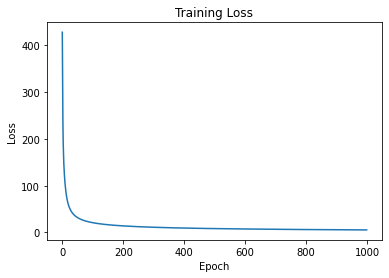

In [97]:
config = { 'learning_rate' : 0.01,
            'num_epoch' : 1000,
            'activation_function' : Relu()
          }

model = train_MSVM(config)

In [104]:
print('\t Accuracy :', MSVM_eval(model, train_version=False))


In test dataset ...
	 Accuracy : 0.098


# Extra problem 2 (3-layer 이상 MLP 구현)

In [58]:
class Relu:
    def __init__(self):
        self.masks = []

    def forward(self, x):
        mask = (x <= 0)
        self.masks.append(mask)
        out = x.copy()
        out[mask] = 0
        return out

    def backward(self, dout):
        mask = self.masks.pop()
        dout[mask] = 0
        return dout

In [59]:
def train_3_layer_MSVM(config):
    # 손실 이력을 저장하는 리스트
    loss_history = []

    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 25

    layer1 = Linear(784, 256)
    activation_function1 = config['activation_function']()
    layer2 = Linear(256, 128)
    activation_function2 = config['activation_function']()
    layer3 = Linear(128, 10)
    msvm_loss = MSVM()
    
    for iter in range(num_epoch):
        # forward
        x = layer1.forward(train_img)
        x = activation_function1.forward(x)
        x = layer2.forward(x)
        x = activation_function2.forward(x)
        x = layer3.forward(x)
        
        # loss
        loss = msvm_loss.forward(x, train_label.squeeze())
        
        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
        
        # backward
        dL = msvm_loss.backward()
        dL = layer3.backward(dL, lr)
        dL = activation_function2.backward(dL)
        dL = layer2.backward(dL, lr)
        dL = activation_function1.backward(dL)
        dL = layer1.backward(dL, lr)
        
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function1'] = activation_function1
    model['layer2'] = layer2
    model['activation_function2'] = activation_function2
    model['layer3'] = layer3
    model['msvm_loss'] = msvm_loss
    
    return model

[epoch 1 / 500] average loss : 3624.958384
[epoch 25 / 500] average loss : 88.029605
[epoch 50 / 500] average loss : 58.404262
[epoch 75 / 500] average loss : 45.005836
[epoch 100 / 500] average loss : 37.014162
[epoch 125 / 500] average loss : 31.652931
[epoch 150 / 500] average loss : 27.717192
[epoch 175 / 500] average loss : 24.673178
[epoch 200 / 500] average loss : 22.241439
[epoch 225 / 500] average loss : 20.251996
[epoch 250 / 500] average loss : 18.598597
[epoch 275 / 500] average loss : 17.176029
[epoch 300 / 500] average loss : 15.967322
[epoch 325 / 500] average loss : 14.913978
[epoch 350 / 500] average loss : 13.988342
[epoch 375 / 500] average loss : 13.164907
[epoch 400 / 500] average loss : 12.429963
[epoch 425 / 500] average loss : 11.767617
[epoch 450 / 500] average loss : 11.166792
[epoch 475 / 500] average loss : 10.615434
[epoch 500 / 500] average loss : 10.113347


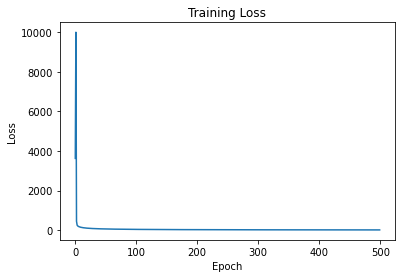

In [65]:
config = { 'learning_rate' : 0.01,
            'num_epoch' : 500,
            'activation_function' : Relu()
          }

model = train_MSVM_3layer(config)

In [67]:
print('\t Accuracy :', MSVM_eval(model, train_version=False))


In test dataset ...
	 Accuracy : 0.8423
